# IRENE

This notebook describes the city of IRENE, which carries the so-called preprocessing of the data, leading to PMAPS.

authors: J.J. Gomez-Cadenas


“For those who pass it without entering, the city is one thing; it is another for those who are trapped by it and never leave. There is the city where you arrive for the first time; and there is another city which you leave never to return. Each deserves a different name; perhaps I have already spoken of Irene under other names; perhaps I have spoken only of Irene.”

In [1]:
import datetime

In [2]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-01-26 23:49:51


In [3]:
from __future__ import print_function
import sys
import os
from glob import glob
from time import time

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math


In [5]:
from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import SystemOfUnits
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.core.wfm_functions as wfm
import invisible_cities.core.tbl_functions as tbl
import invisible_cities.core.peak_functions_c as cpf
import invisible_cities.core.pmaps_functions as pf
import invisible_cities.core.sensor_functions as sf

In [6]:
from invisible_cities.core.core_functions import define_window

In [26]:
from invisible_cities.core.core_functions import lrange

## Preproc Steps

**Irene takes care of the following chores**

1. Deconvolute RWF
2. Compute calibrated sum of PMTs (including MAU threshold)
3. Zero Suppression (ZS) in PMTs
4. S1 search (analysis specific)
5. S2 search (analysis specific) and rebin
6. ZS in SiPMs
7. Select S2 in ZS SiPMs 

For fast pre-proc, all the above steps must be computed on the fly (e.g, minimal access to disk) and
using pre-compiled (cython) functions in calculation-intensive parts (loops)

## Irene step by step

### Input files 

Required files (in IC_DATA)
1. **electrons_40keV_z250_RWF.h5** 
2. **electrons_511keV_z250_RWF.h5**
3. **electrons_1250keV_z250_RWF.h5**
4. **electrons_2500keV_z250_RWF.h5**

### Output files

Will be writen in IC_DATA

1. **electrons_40keV_z250_PMAP.h5** 
2. **electrons_511keV_z250_PMAP.h5**
3. **electrons_1250keV_z250_PMAP.h5**
4. **electrons_2500keV_z250_PMAP.h5**

## Case 1: electrons of 40 keV

In [7]:
RWF_file = os.environ['IC_DATA']  + '/electrons_40keV_z250_RWF.h5'
PMAP_file = os.environ['IC_DATA']  + '/electrons_40keV_z250_PMAP.h5'

In [8]:
h5rwf = tb.open_file(RWF_file,'r')

### pmtrwf and sipmrwf vectors

To get vectors use **get_vectors(file)** in tbl_functions

In [9]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [10]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 10
        Number of PMTs = 12
        PMTWL = 32000
        Number of SiPMs = 1792
        SiPMWL = 800
      


### Access to data base and definition of units

In [11]:
DataPMT = load_db.DataPMT()
units = SystemOfUnits()
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c = abs(DataPMT.coeff_c.values)
coeff_blr = abs(DataPMT.coeff_blr.values)
DataSiPM = load_db.DataSiPM()
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [12]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_c,coeff_blr,adc_to_pes,noise_rms,sigma
0,0,0,1,1,-23.9414,65.7785,0.000003,0.001632,-24.3395,0.7060,7.73100
1,1,18,3,1,-44.9951,-53.6231,0.000003,0.001632,-24.8580,0.8744,8.82000
2,2,1,2,1,68.9365,-12.1554,0.000003,0.001611,-26.2934,0.7213,8.01375
3,3,19,4,1,0.0000,185.0000,0.000003,0.001599,-26.4110,0.7624,8.42224
4,4,27,C,1,-118.9160,141.7180,0.000003,0.001567,-26.7098,0.7921,6.23125
5,5,26,B,1,-182.1890,32.1249,0.000004,0.001650,-22.4456,0.8660,5.65180
6,6,9,A,1,-160.2150,-92.5000,0.000003,0.001593,-23.3552,0.7062,7.37840
7,7,8,9,1,-63.2737,-173.8430,0.000003,0.001612,-33.8821,0.7278,11.94840
8,8,23,8,1,63.2737,-173.8430,0.000003,0.001601,-21.8220,0.7303,6.11073
9,9,22,7,1,160.2150,-92.5000,0.000003,0.001593,-25.8020,0.7160,7.46200


In [13]:
DataSiPM.head()

,SensorID,ChannelID,Active,X,Y,adc_to_pes
0,1000,1025,1,-235.0,45.0,15.8202
1,1001,1024,1,-235.0,55.0,16.1037
2,1002,1027,1,-235.0,65.0,17.2044
3,1003,1026,1,-235.0,75.0,15.5304
4,1004,1016,1,-235.0,85.0,15.1095


### Step 1: Deconvolution (from RWF to CWF)

#### A deconvolution algorithm (V. Herrero, JJGC) takes the distorted RWF and produces corrected waveforms (CWF) where the effect of the FEE has been deconvoluted.

Found in module **invisible_cities.sierpe.blr**

Signature: **deconv_pmt(RWF, coeff_c, coeff_blr, n_baseline=28000, thr_trigger=5)**

**Run over one event**

In [14]:
event = 0
BLR = pmtblr[event]
RWF = pmtrwf[event]

In [15]:
t0 = time()
CWF = blr.deconv_pmt(RWF, coeff_c, coeff_blr, n_baseline=28000, thr_trigger=5)
t1 = time()        
dt = t1 - t0
print("run  in {} s".format(dt))

run  in 0.15259695053100586 s


To plot the waveforms use **invisible_cities.core.wfm_functions** function:

**plot_pmt_waveforms(WF)** where WF is a vector of waveforms

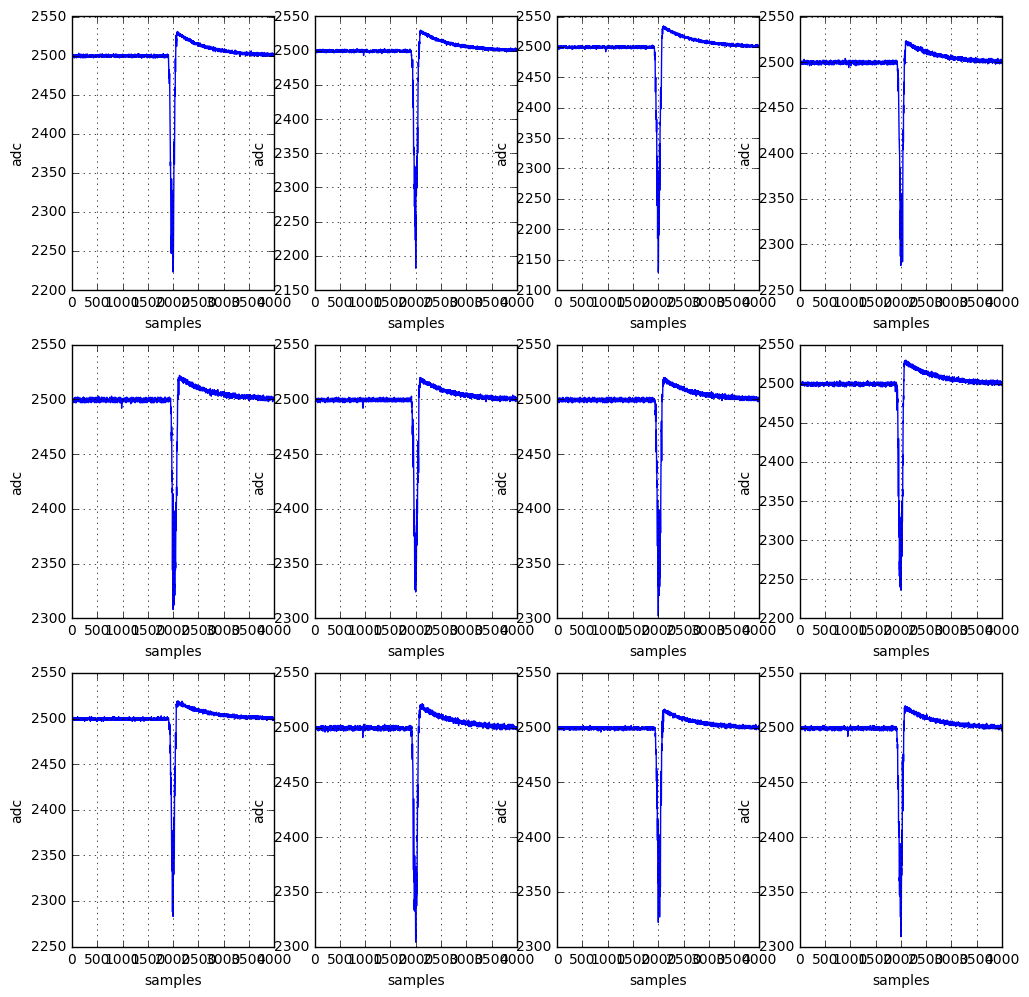

In [16]:
wfm.plot_pmt_waveforms(RWF, zoom=True, window_size=2000)

Notice the small S1, which is observed in a few of the waveforms. S1 for 40 keV electrons is small (a few PES) and thus the probability of observing zero PES in one of the PMTs is high. 

#### Plot BLR on top of CWF. Excellent match

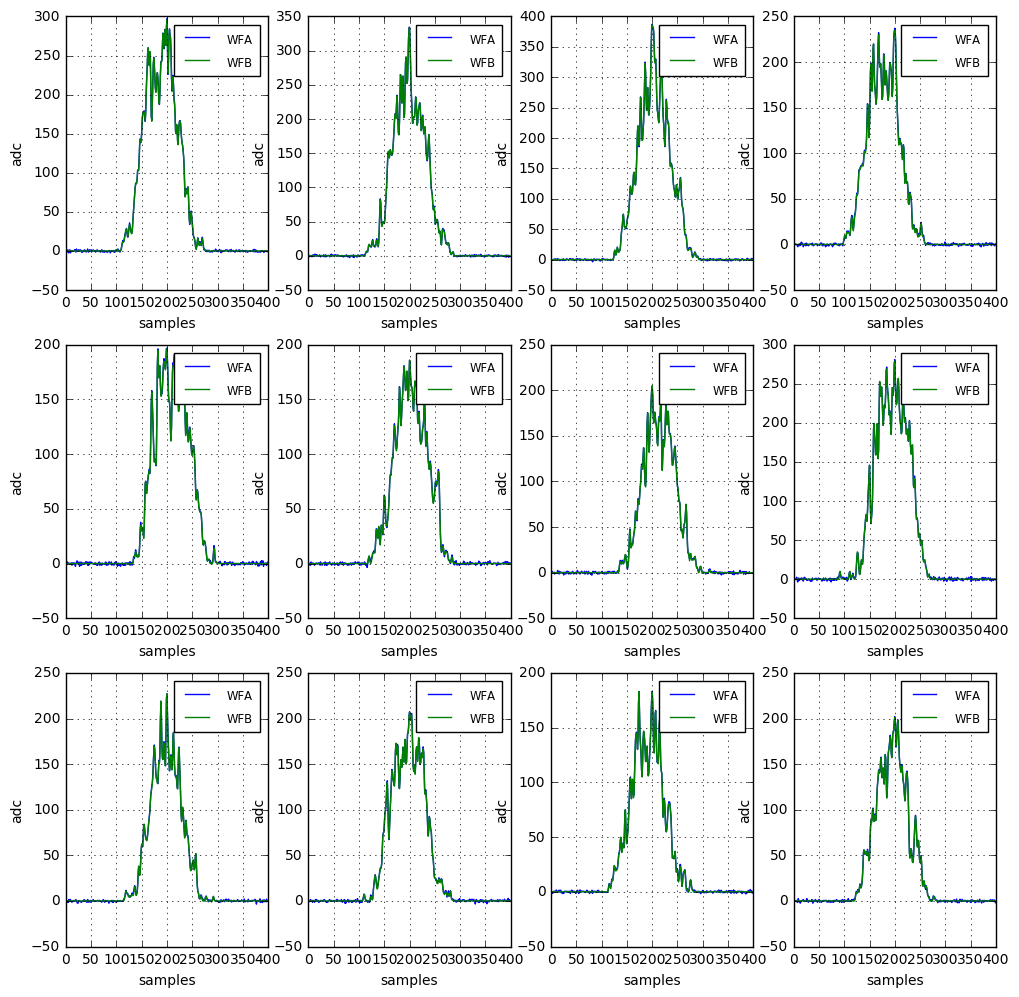

In [17]:
wfm.plot_wfa_wfb(CWF, BLR, zoom=True, window_size=200) 

### Step 2: calibrated PMT sum

#### The PMTs of the energy plane are calibrated (dividing by calibration constants) and added. 

In [19]:
event=0
t0 = time()
CWF = blr.deconv_pmt(RWF, coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
t1 = time()        
dt = t1 - t0

print("run over  one event  in {} s".format(dt))

run over  one event  in 0.15275001525878906 s


In [20]:
tstep = 25
signal_t = np.arange(0., PMTWL * tstep, tstep)

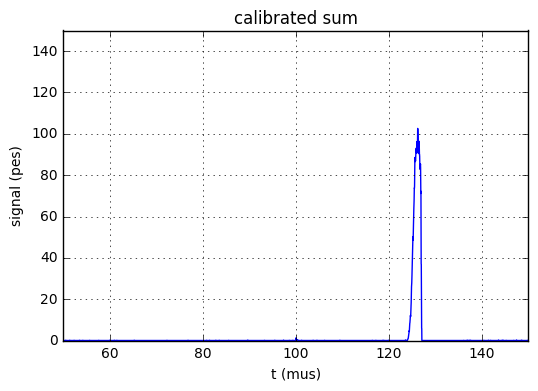

In [21]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=50, signal_end=150, 
                ymax = 150, 
                t_units='mus', units="pes")

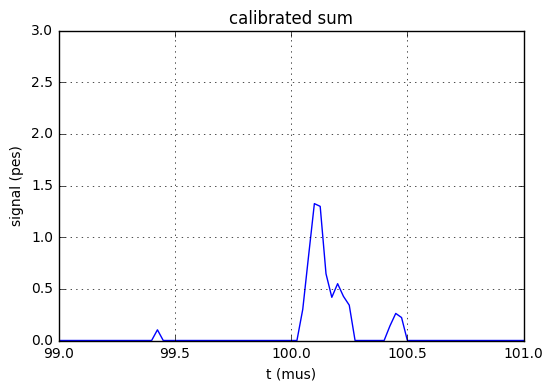

In [22]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=99, signal_end=101, 
                ymax = 3, t_units='mus', units="pes")

S1 is very weak. A cut on 1.5 pes would completely kill the signal. 

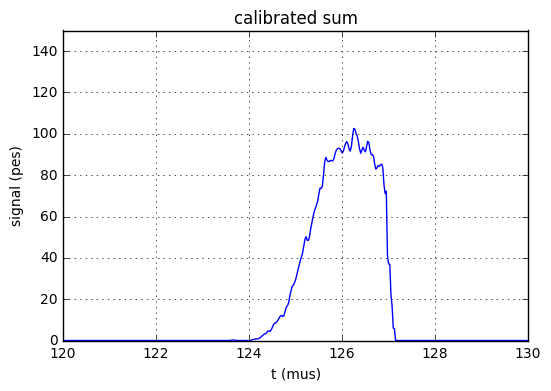

In [23]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=120, signal_end=130, 
                ymax = 150, 
                t_units='mus', units="pes")

S2 shows the effect of the EL grid. The width of S2 is of the order of 3 mus (width of the grid). 

#### Test: the calibrated sum of the BLR and the CWF must be very close

In [54]:
def calibrated_sum_cwf_blr_diff(pmtrwf, pmtblr, event_list=[0], 
                                plot=False, window=200,
                                n_MAU=100, thr_MAU=3):
    """Test that the calibrated sum of the BLR and the CWF is the same within tolerance"""
    
    DataPMT = load_db.DataPMT()
    coeff_c = abs(DataPMT.coeff_c.values)
    coeff_blr = abs(DataPMT.coeff_blr.values)
    adc_to_pes = abs(DataPMT.adc_to_pes.values)
    DIFF = []
    for event in event_list:     
        CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
        csum_cwf = cpf.calibrated_pmt_sum(CWF, adc_to_pes, 
                                          n_MAU=n_MAU, thr_MAU=thr_MAU)
        csum_blr = cpf.calibrated_pmt_sum(pmtblr[event].astype(np.float64), adc_to_pes, 
                                          n_MAU=n_MAU, thr_MAU=thr_MAU)
        diff = csum_cwf - csum_blr
        norm = np.sum(csum_blr)
        if plot:
            wfm.plot_waveform(diff, zoom=plot, window_size=window)
            plt.show()
        DIFF.append(np.sum(diff)/norm)
    return DIFF


In [55]:
diff = calibrated_sum_cwf_blr_diff(pmtrwf, pmtblr, event_list=lrange(10))

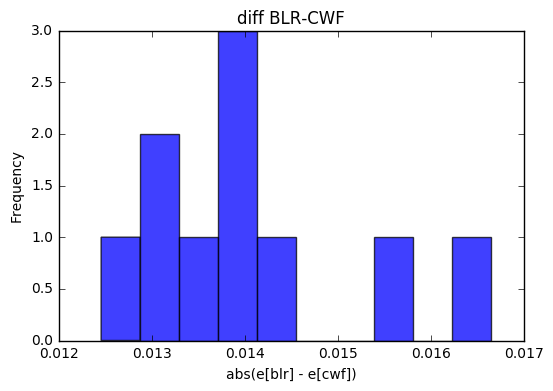

In [56]:
mpl.histo(diff, nbins=10, 
          title="diff BLR-CWF", xlabel="abs(e[blr] - e[cwf])", ylabel="Frequency")

### Step 3: Zero suppression

A cut on 0.5 pes is set in the calibrated sum to maximize S1 efficiency

In [70]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=0.5*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
t1 = time()        
dt = t1 - t0

print("run  in {} s".format(dt))

run  in 0.13994503021240234 s


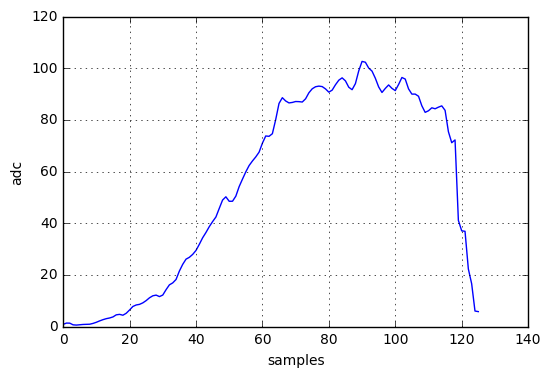

In [71]:
wfm.plot_waveform(wfzs_ene, zoom=True, window_size=200)

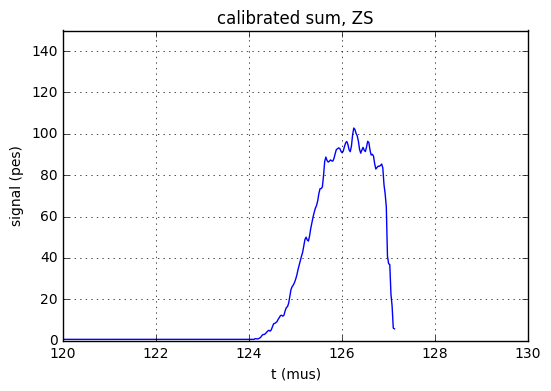

In [33]:
mpl.plot_signal(wfzs_t/units.mus, wfzs_ene, title="calibrated sum, ZS",
                signal_start=120, signal_end=130, 
                ymax = 150, 
                t_units='mus', units="pes")

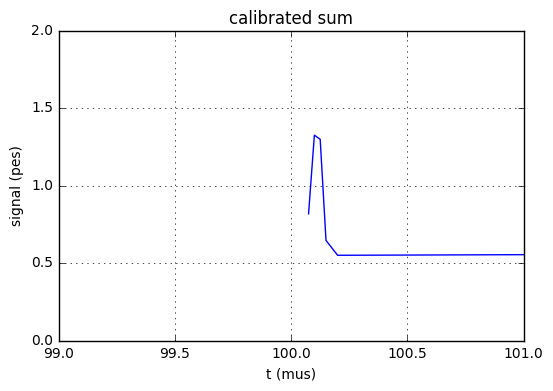

In [72]:
mpl.plot_signal(wfzs_t/units.mus, wfzs_ene, title="calibrated sum",
                signal_start=99, signal_end=101, 
                ymax = 2, t_units='mus', units="pes")

In [73]:
CWF = wfm.cwf_from_rwf(pmtrwf, lrange(10))

In [79]:
def compare_csum_zsum(CWF):
    """Compares calibrated sum and ZS sum for the CWF"""
    
    DIFF = []
    for cwf in CWF:
        csum = cpf.calibrated_pmt_sum(cwf, adc_to_pes, n_MAU=100, thr_MAU=3) 
        wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=0.5*units.pes)
        dff = abs(np.sum(csum) - np.sum(wfzs_ene))
        norm = np.sum(csum)
        DIFF.append(dff/norm)
    return DIFF


In [80]:
diff = compare_csum_zsum(CWF)

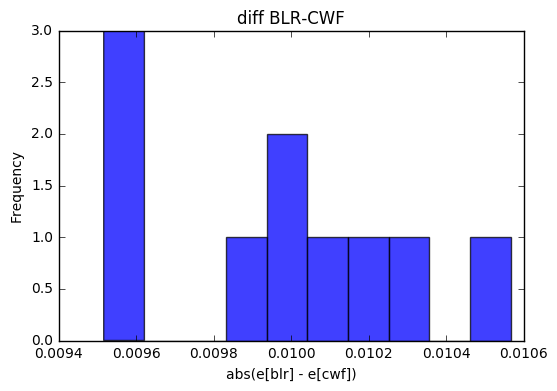

In [81]:
mpl.histo(diff, nbins=10, 
          title="diff CSUM-ZSUM", xlabel="abs(e[csum] - e[zsum])", ylabel="Frequency")

### Step 4: Find S12 

**S1 and S2 signals are found from the ZS waveform**

1. S1: Search the first 600 mus (in the MC S1 is always at 100 mus but not in the data). The S1 signal must be at least 100 ns long (this is the minimum length of S1 after the shaping of the electronics) and not larger than 500 ns. The stride counts the number of bins that need to have signal. A stride of 4 means that there must be at least 0.5 pes each 100 ns (4 x 25 ns, where 25 ns is the DAQ sampling time). 

2. Search in the whole window (in the MC data, S2 can be anywhere after 100 mus, in the data it will tipically be placed in the middle of the DAQ window, thus one would search in the range [600, 1200] ns. The minimum length is 120 bins (120 x 25 = 3000 ns), no limit in the max length of the signal is not restricted (in order to avoid a bias, but one could further select the signal with a max width cut), the stride is taken to 40 (1 mus) and the signal is rebinned also in bins of 1 mus

In [82]:
event = 0
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=0.5*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=4, lmax=16, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=300, stride=40,
                 rebin=True, rebin_stride=40)
t1 = time()        
dt = t1 - t0

print("run  in {} s".format(dt))

run  in 0.13540291786193848 s


#### S1 and and S2 signals

In [83]:
S1

{0: [array([ 100075.,  100100.,  100125.,  100150.,  100200.]),
  array([ 0.8172365 ,  1.32459464,  1.29820859,  0.64577964,  0.54973457])]}

In [84]:
S2

{0: [array([ 124612.5,  125612.5,  126612.5,  127125. ]),
  array([  511.0073551 ,  2984.15844702,  3224.98400361,     5.7610632 ])]}

In [85]:
def times_s2_in_mus(S2, peak=0):
    """Find the times of the S2 in mus"""
    sgn = S2[peak]
    T = sgn[0]
    return T/units.mus

In [86]:
times_s2_in_mus(S2, peak=0)

array([ 124.6125,  125.6125,  126.6125,  127.125 ])

There is one S2 in this event. The format of S2 is:

**{s2_number:[array(T), array(E)]}**

where the ZS waveform is expressed by the list **[array(T), array(E)]**

#### Structure of S1/S2
1. Dictionary index counts the number of peaks
2. Dict values are a list [T,E], where T and E are numpy arrays of Time and Energy

#### Run the whole chain for the next event in the file (event 1)

In [87]:
event = 1
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=0.25*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0*units.mus,  tmax=1100*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)
t1 = time()        
dt = t1 - t0

print("run  in {} s".format(dt))

run  in 0.13718819618225098 s


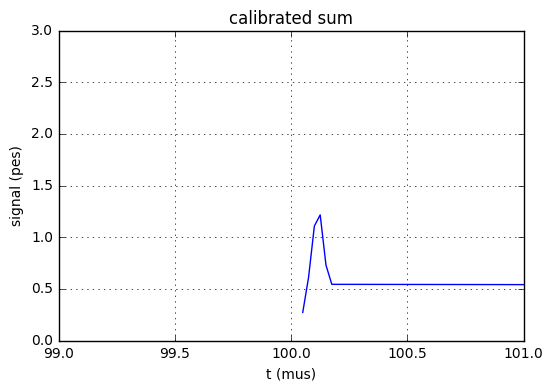

In [88]:
mpl.plot_signal(wfzs_t/units.mus, wfzs_ene, title="calibrated sum",
                signal_start=99, signal_end=101, 
                ymax = 3, t_units='mus', units="pes")

In [89]:
S1

{0: [array([ 123350.,  123375.,  123400.,  123500.,  123525.,  123575.,
          123600.,  123625.,  123650.,  123675.,  123700.,  123725.]),
  array([ 0.46760162,  0.51840538,  0.3496526 ,  0.50851531,  0.46820267,
          0.45575481,  0.64846997,  0.63114433,  0.68192811,  0.86272166,
          0.52914595,  0.33793881])]}

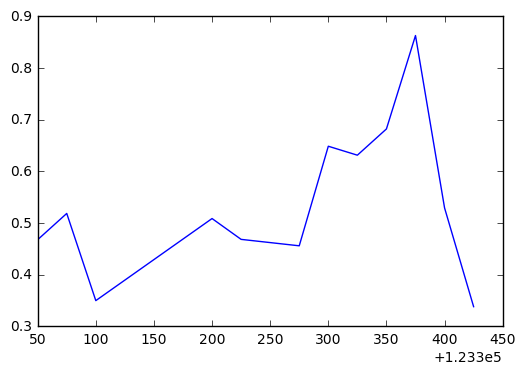

In [90]:
plt.plot(S1[0][0],S1[0][1])

Number of photoelectrons in S1

In [91]:
np.sum(S1[0][1])

6.4594812018829062

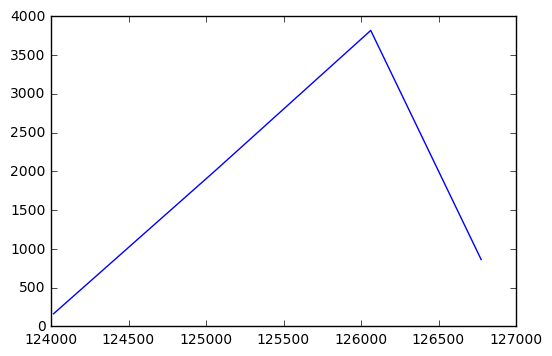

In [92]:
plt.plot(S2[0][0],S2[0][1])

Number of photoelectrons in S2

In [93]:
np.sum(S2[0][1])

6861.5417168829053

Width

In [94]:
(S2[0][0][-1] - S2[0][0][0]) / units.mus

2.75875

number of peaks = 1
S12 number = 0, samples = 12 sum in pes =6.459481201882906


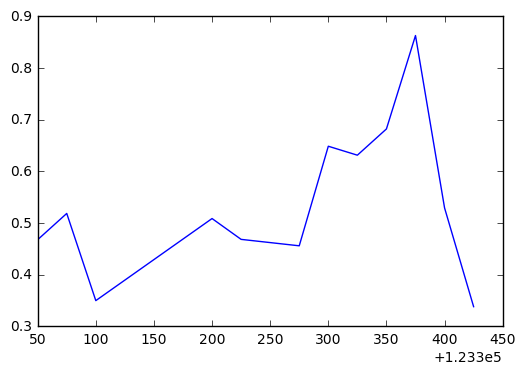

In [95]:
pf.scan_s12(S1)

number of peaks = 1
S12 number = 0, samples = 4 sum in pes =6861.541716882905


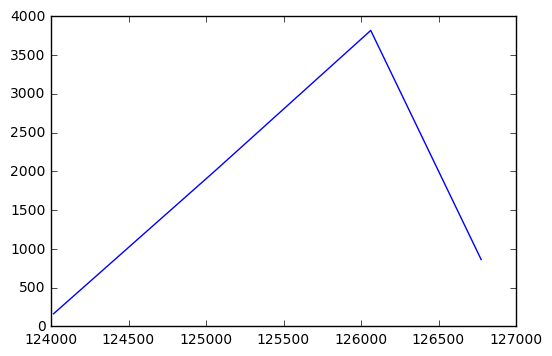

In [96]:
pf.scan_s12(S2)

### SiPMs

In the case of MC Many of the SiPMs will contain exact zeros, since they had been ZS already at DIOMIRA level. For example, if we plot the first 16 SiPMs, we can see they are all exactly zero.

Find SiPMs with signal: the threshold is set to 1 adc count to simply get rid of all SiPMs which have exactly zero signal (the output of DIOMIRA is already ZS)

In [97]:
event=1
sipm_i = sf.sipm_with_signal(sipmrwf[event], thr=1*units.adc) 

In [98]:
sipm_i

array([ 696,  767, 1024, 1095])

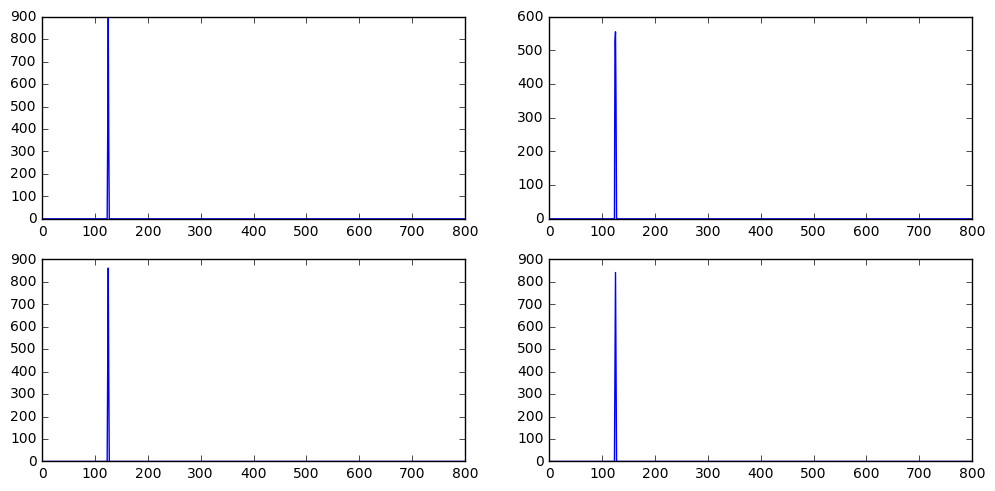

In [99]:
sf.plot_sipm_list(sipmrwf[event], sipm_i)

### Subtract baseline, and set a cut to supress dark current

in the MC the data comes already ZS. In data one needs to set a cut in order to ZS the SiPMs. 

In [100]:
event=1
t0 = time()
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=25*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
t1 = time()        
dt = t1 - t0

print("run in {} s".format(dt))
print('number of SiPM with signal = {}'.format(len(SIPM)))

run in 0.18425488471984863 s
number of SiPM with signal = 4


### PMAPS

#### Structure of a PMAP
1. S1 and S2 are dictionaries: each dictionary index is one S1/S2 candidate. Each dictionary value is a list which contains two elements. Element [0] is a np vector of times, element[1] is a np vector of energies in pes.
2. S2Si is a dictionary. Each index correspond to the S2 index. Each value is a list, whose length is equal to the number of SiPM with no zero signal in the S2 window. The list has as a first element the SiPM index and as a second the energy of each SiPM in the S2 window. Time is not neeeded (comes with S2).

#### S2 window
1. Given an S2 (T,E), obtain the relevant index range. 
2. Given a vector with SIPMs (energies above threshold), returns
    a list of np arrays. Each element of the list is the S2 window 
    in the SiPM (if not zero)
3. Given a vector with SIPMs (energies above threshold), and a 
    dictionary of S2s, S2d, returns a dictionary of SiPMs-S2.
    Each index of the dictionary correspond to one S2 and is
    a list of np arrays. Each element of the list is the S2 window 
    in the SiPM (if not zero)

## The full pre-proc 

In [101]:
event = 1
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=0.5*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=6, lmax=16, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0*units.mus,  tmax=1190*units.mus, 
                 lmin=100, lmax=300, stride=40,
                 rebin=True, rebin_stride=40)
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=25*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
S2Si = pf.sipm_s2_dict(SIPM, S2, thr=25*units.pes)
t1 = time()        
dt = t1 - t0
    
print("run in {} s".format(dt))

run in 0.30556416511535645 s


#### Plot SiPMs

In [102]:
def scan_SIPM(SIPM):
    for i in range(len(SIPM)):
        for j in range(1):
            print('SIPM[{}][{}] = {}'.format(i,j, SIPM[i][j]))

In [103]:
scan_SIPM(SIPM)

SIPM[0][0] = 696
SIPM[1][0] = 767
SIPM[2][0] = 1024
SIPM[3][0] = 1095


In [104]:
sipm_i = sf.sipm_with_signal(sipmrwf[event], thr=1*units.adc) 

In [105]:
sipm_i

array([ 696,  767, 1024, 1095])

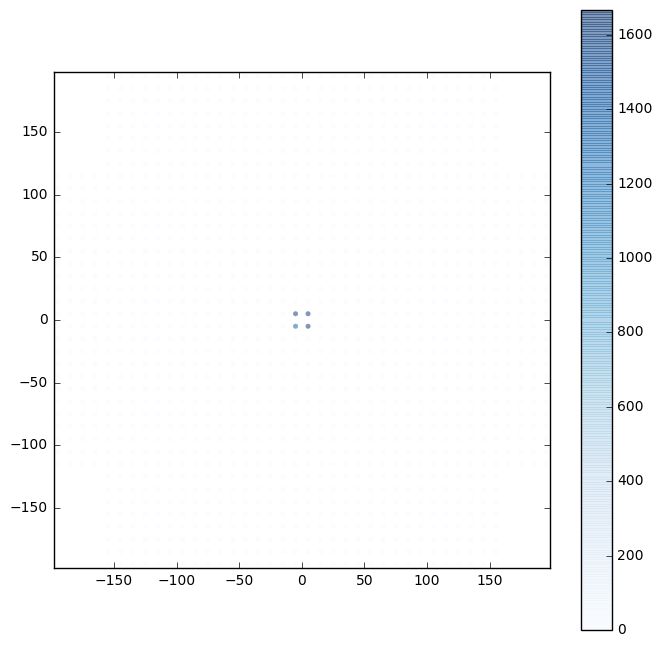

In [112]:
sf.plot_sensor_list_ene_map(sipmrwf[event], sipm_i, stype='SiPM')

In [113]:
S2

{0: [array([ 124196.25,  125237.5 ,  126237.5 ,  126862.5 ]),
  array([  314.04936236,  2502.27225286,  3729.59914333,   312.83430301])]}

In [62]:
S2Si

{0: [[696, array([  0.        ,  56.85785018])],
  [767, array([ 33.85430537,  36.58230438])],
  [1024, array([  0.       ,  51.8310675])],
  [1095, array([ 26.64186223,  50.74481453])]]}

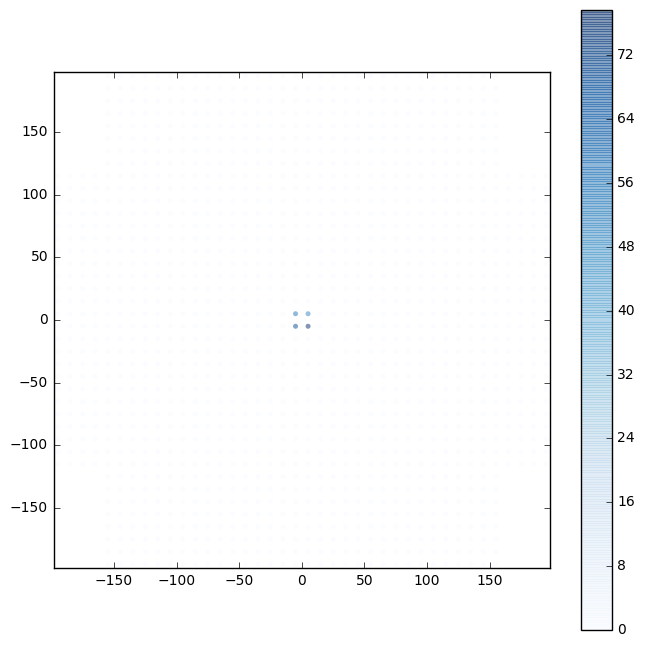

In [114]:
pf.plot_s2si_map(S2Si)

## Case 2: electrons of 511 keV

In [115]:
RWF_file = os.environ['IC_DATA']  + '/electrons_511keV_z250_RWF.h5'
PMAP_file = os.environ['IC_DATA']  + '/electrons_511keV_z250_PMAP.h5'

In [116]:
if h5rwf:
    h5rwf.close()

In [117]:
h5rwf = tb.open_file(RWF_file,'r')

In [118]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [119]:
event = 0
BLR = pmtblr[event]
RWF = pmtrwf[event]

In [120]:
event=0
t0 = time()
CWF = blr.deconv_pmt(RWF, coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
t1 = time()        
dt = t1 - t0

print("run over  one event  in {} s".format(dt))

run over  one event  in 0.13815808296203613 s


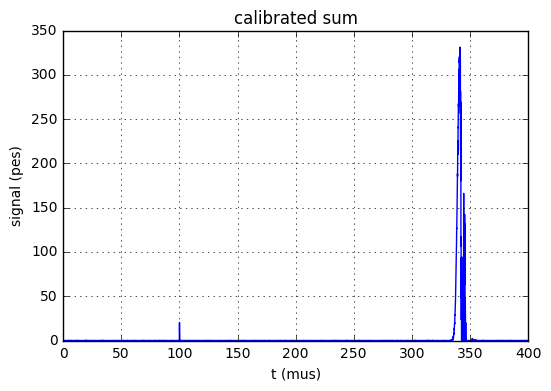

In [121]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=0, signal_end=400, 
                ymax = 350, 
                t_units='mus', units="pes")

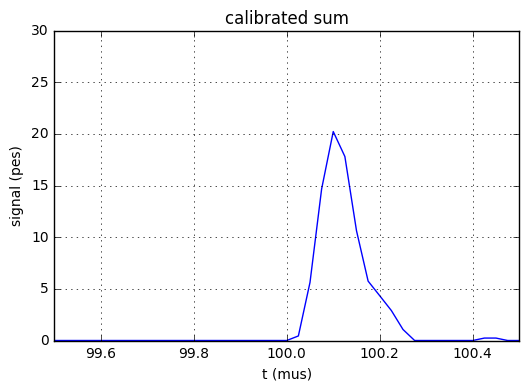

In [122]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=99.5, signal_end=100.5, 
                ymax = 30, 
                t_units='mus', units="pes")

S1 is much stronger already. A cut on 1 pes and a width of 200 ns will be effective.

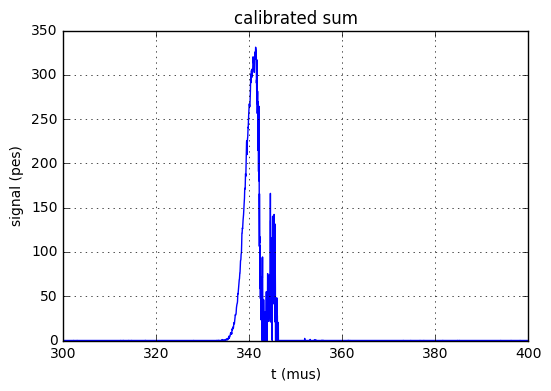

In [123]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=300, signal_end=400, 
                ymax = 350, 
                t_units='mus', units="pes")

**Parameters for 511 keV electrons**

1. Cut on CSUM raised to 1 pes.
2. Width of S1 raised to 8 samples (200 ns)

In [124]:
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1.0*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0*units.mus,  tmax=1190*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=25*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
S2Si = pf.sipm_s2_dict(SIPM, S2, thr=25*units.pes)
t1 = time()        
dt = t1 - t0
    
print("run in {} s".format(dt))

run in 0.30970001220703125 s


number of peaks = 1
S12 number = 0, samples = 9 sum in pes =82.97056354604726


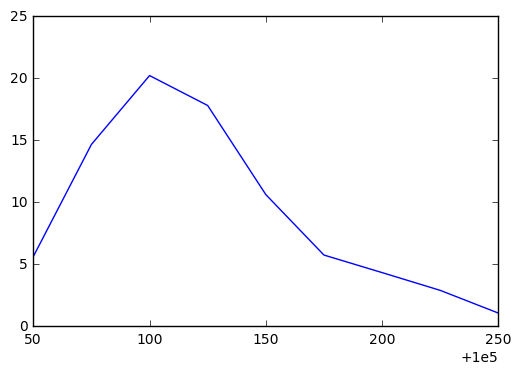

In [125]:
pf.scan_s12(S1)

number of peaks = 1
S12 number = 0, samples = 11 sum in pes =49280.48022435642


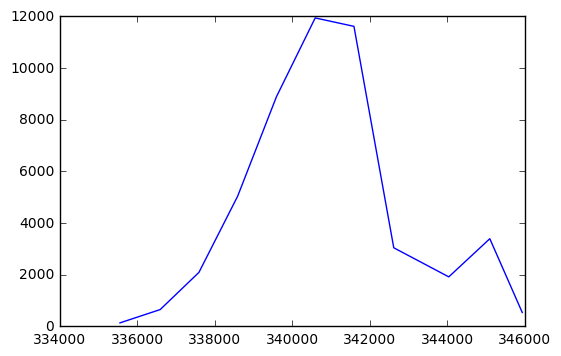

In [126]:
pf.scan_s12(S2)

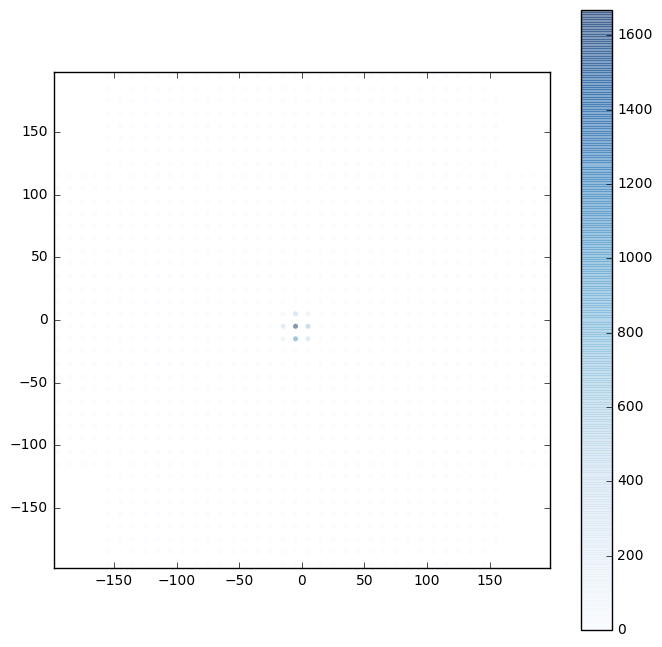

In [127]:
pf.plot_s2si_map(S2Si)

In [128]:
pf.scan_s2si_map(S2Si)

SiPM number = 688, total energy = 65.77307007667487
SiPM number = 696, total energy = 493.8955438428367
SiPM number = 758, total energy = 176.53710203370423
SiPM number = 759, total energy = 405.8216605119063
SiPM number = 765, total energy = 26.817491691555627
SiPM number = 766, total energy = 1066.744009203112
SiPM number = 767, total energy = 1667.9421144590444
SiPM number = 1024, total energy = 179.53150739486978
SiPM number = 1094, total energy = 444.7736632186517
SiPM number = 1095, total energy = 689.0903103709311


## Case 3: electrons of 1250 keV

In [129]:
RWF_file = os.environ['IC_DATA']  + '/electrons_1250keV_z250_RWF.h5'
PMAP_file = os.environ['IC_DATA']  + '/electrons_1250keV_z250_PMAP.h5'

In [130]:
if h5rwf:
    h5rwf.close()

In [132]:
h5rwf = tb.open_file(RWF_file,'r')

In [133]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [134]:
event = 0
BLR = pmtblr[event]
RWF = pmtrwf[event]

In [135]:
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1.0*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0*units.mus,  tmax=1190*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=25*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
S2Si = pf.sipm_s2_dict(SIPM, S2, thr=25*units.pes)
t1 = time()        
dt = t1 - t0
    
print("run in {} s".format(dt))

run in 0.32508397102355957 s


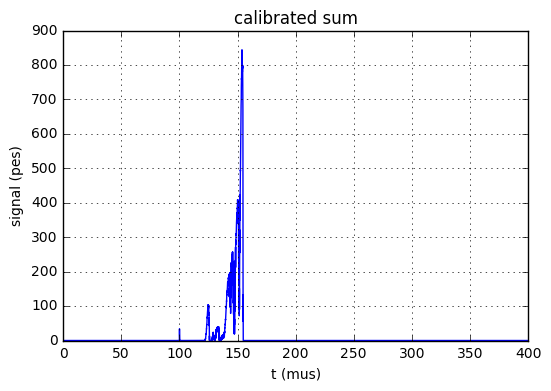

In [142]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=0, signal_end=400, 
                ymax = 900, 
                t_units='mus', units="pes")

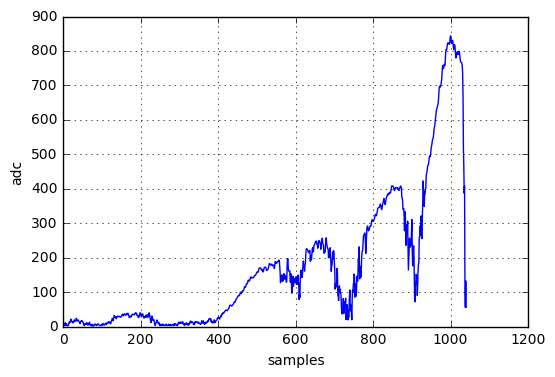

In [144]:
wfm.plot_waveform(wfzs_ene, zoom=True, window_size=1000)

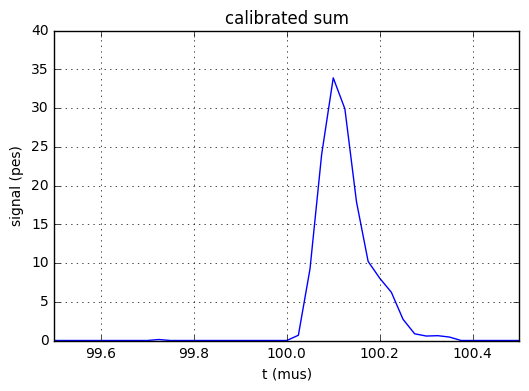

In [147]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=99.5, signal_end=100.5, 
                ymax = 40, 
                t_units='mus', units="pes")

number of peaks = 1
S12 number = 0, samples = 9 sum in pes =142.08369492864674


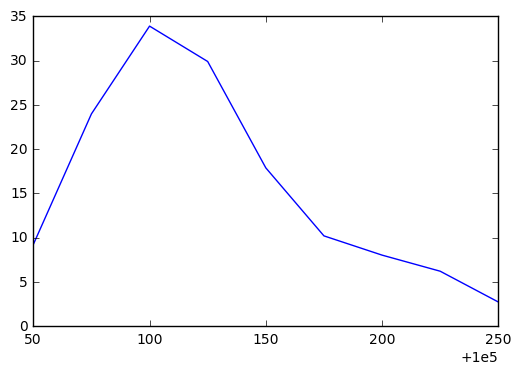

In [148]:
pf.scan_s12(S1)

number of peaks = 2
S12 number = 0, samples = 4 sum in pes =8180.876974363747
S12 number = 1, samples = 27 sum in pes =179154.23869700832


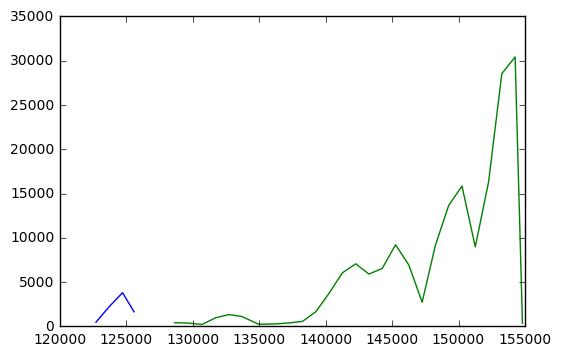

In [149]:
pf.scan_s12(S2)

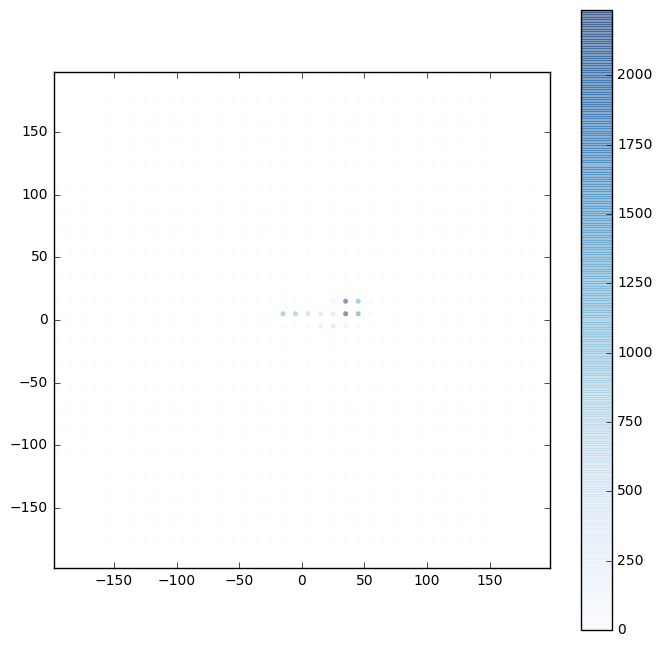

In [150]:
pf.plot_s2si_map(S2Si)

## Case 4: electrons of 2500 keV

In [158]:
RWF_file = os.environ['IC_DATA']  + '/electrons_2500keV_z250_RWF.h5'
PMAP_file = os.environ['IC_DATA']  + '/electrons_2500keV_z250_PMAP.h5'

In [159]:
if h5rwf:
    h5rwf.close()

In [160]:
h5rwf = tb.open_file(RWF_file,'r')

In [161]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [162]:
event = 0
BLR = pmtblr[event]
RWF = pmtrwf[event]

In [163]:
t0 = time()
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr)
csum = cpf.calibrated_pmt_sum(CWF, adc_to_pes, n_MAU=100, thr_MAU=3) 
wfzs_ene, wfzs_indx = cpf.wfzs(csum, threshold=1.0*units.pes)
wfzs_t = cpf.time_from_index(wfzs_indx)
S1 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0,  tmax=590*units.mus, 
                 lmin=8, lmax=20, stride=4,
                 rebin=False)
S2 = cpf.find_S12(wfzs_ene, wfzs_indx, tmin=0*units.mus,  tmax=1190*units.mus, 
                 lmin=100, lmax=1000000, stride=40,
                 rebin=True, rebin_stride=40)
sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm, thr=25*units.pes, n_MAU=100)
SIPM = cpf.select_sipm(sipm)
S2Si = pf.sipm_s2_dict(SIPM, S2, thr=25*units.pes)
t1 = time()        
dt = t1 - t0
    
print("run in {} s".format(dt))

run in 0.30994200706481934 s


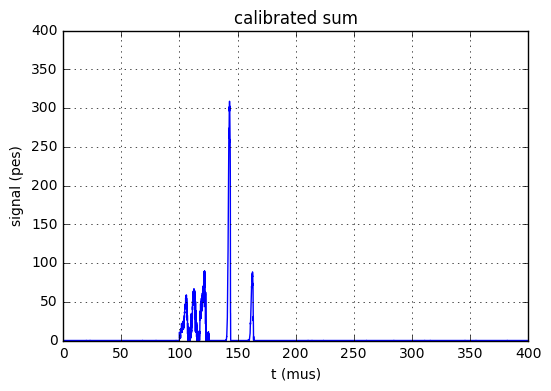

In [165]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=0, signal_end=400, 
                ymax = 400, 
                t_units='mus', units="pes")

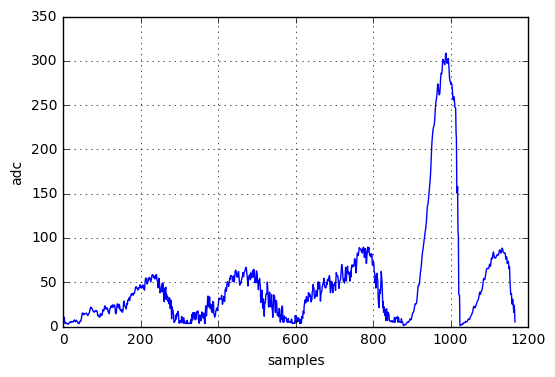

In [168]:
wfm.plot_waveform(wfzs_ene, zoom=True, window_size=3000)

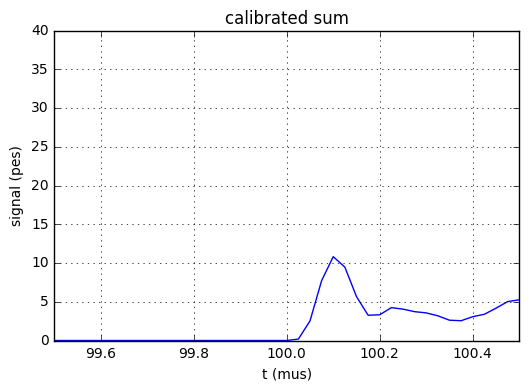

In [169]:
mpl.plot_signal(signal_t/units.mus, csum, title="calibrated sum",
                signal_start=99.5, signal_end=100.5, 
                ymax = 40, 
                t_units='mus', units="pes")

number of peaks = 3
S12 number = 0, samples = 10 sum in pes =78.0001018850378
S12 number = 1, samples = 8 sum in pes =46.27201794136039
S12 number = 2, samples = 15 sum in pes =114.95626165488916


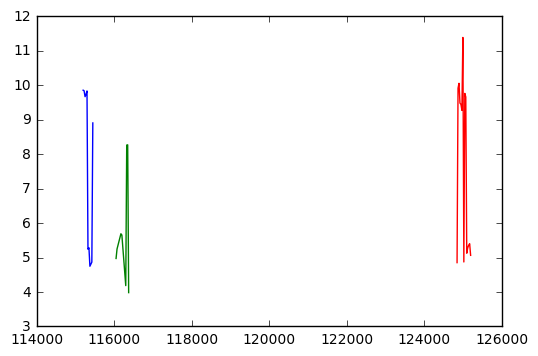

In [170]:
pf.scan_s12(S1)

number of peaks = 3
S12 number = 0, samples = 22 sum in pes =28104.43985661862
S12 number = 1, samples = 4 sum in pes =22329.16031640832
S12 number = 2, samples = 4 sum in pes =6566.607737381873


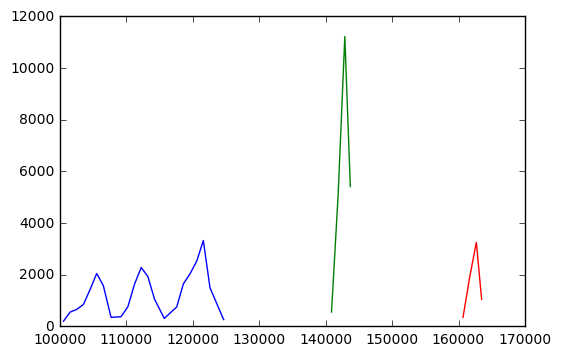

In [171]:
pf.scan_s12(S2)

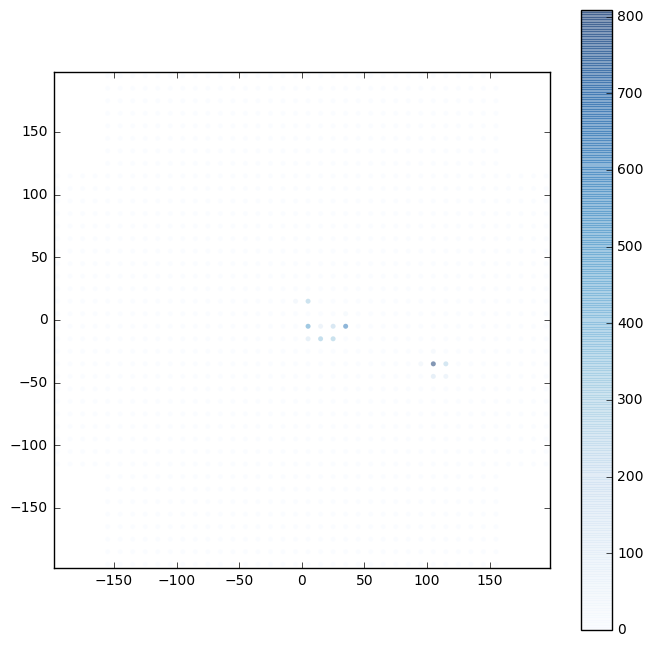

In [172]:
pf.plot_s2si_map(S2Si)

End of notebook